In [1]:
# change to True if you use Google Colaboratory:
GoogleColaboratory = False

In [2]:
import os, sys, importlib

if GoogleColaboratory :

    !pip3 install healpy
    
    user = "mahlers77"
    repo = "KSETA2023"

    if os.path.isdir(repo):
        !rm -rf {repo}

    !git clone https://github.com/{user}/{repo}.git

    if not repo in sys.path:
        sys.path.insert(1, repo)

else :
    repo = "."

#for path in sys.path : 
#  print(path)

In [3]:
import CRAToPy
from CRAToPy.coordinates import *
from CRAToPy.datatools import Lambertview
from CRAToPy.EastWest import EWderivative
from CRAToPy.EastWest import EWdipole

In [4]:
import numpy as np
import healpy as H
from pylab import *
from astropy.time import Time
from scipy.special import erfinv
from scipy.special import erf

In [5]:
#geographic location of Auger (in degree)
LATITUDE = -35.2
LONGITUDE = -69.5

#number of declination steps
nside = 32
npix = H.nside2npix(nside)

#number of time steps
ntimes = 360

lines = [line.strip() for line in open(repo + "/data/Auger2017/Arrival_directions_8EeV_Science_2017.dat")]
Augerdata = np.array([line.split() for line in lines[33:]])

dec = np.array([float(x)/180.*np.pi for x in Augerdata.transpose()[2]])
ra = np.array([float(x)/180.*np.pi for x in Augerdata.transpose()[3]])
time = np.array([float(x) for x in Augerdata.transpose()[6]])

# the following lines determine the sidereal time for timebins
time0 = Time(0.0,format='unix',location=(LONGITUDE,LATITUDE))
sidereal0 = time0.sidereal_time('mean')
hourangle0 = sidereal0.hourangle

omegaorbit = 2*np.pi/(365.24217*24.0*60.0*60.0) 
omegasol = 2*np.pi/(24.0*60.0*60.0)
omega = omegasol + omegaorbit

#deltaRA = (ra - omega*time - hourangle0/24.*2.0*np.pi) % (2.*np.pi)
#pixels = Lambert_ang2pix(ndec,dec,deltaRA)

hourangle = (omega*time + hourangle0/24.*2.0*np.pi) % (2.*np.pi)
timebins = np.digitize(hourangle,np.linspace(0.0, 2.*np.pi, num=ntimes+1))-1

In [6]:
vx = np.cos(ra)*np.cos(dec)
vy = np.sin(ra)*np.cos(dec)
vz = np.sin(dec)

pixelLC = []
for i in range(0,len(Augerdata)) :
    vLCx,vLCy,vLCz = EQ2LC_vector(vx[i],vy[i],vz[i],hourangle[i],LATITUDE/180.*np.pi)
    vLC = np.transpose([vLCx,vLCy,vLCz])
    theta, phi = H.vec2ang(vLC)
    pixelLC.append(H.ang2pix(nside,theta,phi))
    
pixelLC = np.array(pixelLC)

In [7]:
# create maps of CR data for ntimes sidereal time bins:
CRmap = np.zeros((ntimes,npix), dtype=np.double)

for i in range(0,len(Augerdata)) :
    CRmap[timebins[i]][pixelLC[i]] += 1.0 

In [8]:
# alternative, we can use the East-West method

#maximal zenith (in degree)
THETAMAX = 80.

NBINS = 36

EW, dEW, EWint, dalpha = EWderivative(nside,ntimes,NBINS,THETAMAX/180.*np.pi,CRmap)
out = EWdipole(NBINS,EW,dEW)

In [9]:
print("dipole fit summary:")
print('amplitude = ' + format(out[0], '.4f') + ' +/- ' + format(out[1], '.4f'))
print('RA phase = ' + format(out[2], '.2f') + ' +/- ' + format(out[3], '.2f') + ' deg')

dipole fit summary:
amplitude = 0.0797 +/- 0.0158
RA phase = 135.75 +/- 11.31 deg


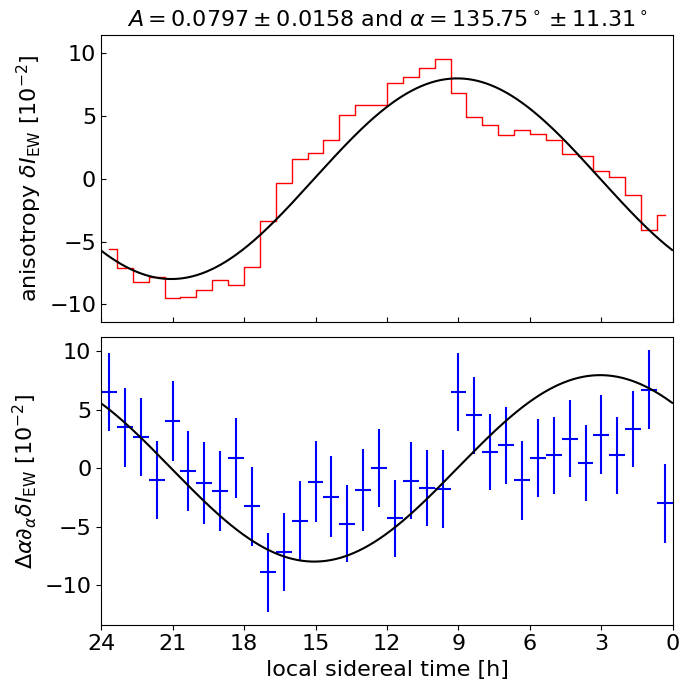

In [10]:
fig = figure(dpi=100,tight_layout=True,figsize=(7, 7))

ax = fig.add_subplot(2,1,2)

ylabel(r'$\Delta\alpha\partial_\alpha \delta I_{\rm EW}$ [$10^{-2}$]',fontsize=16)
xlabel(r'local sidereal time [h]',fontsize=16)

xlim([0,2*np.pi])

mymax = max(np.abs(dalpha*100*np.array(EW)))

for tick in ax.xaxis.get_major_ticks() :
    tick.label.set_fontsize(16) 

for tick in ax.yaxis.get_major_ticks() :
    tick.label.set_fontsize(16)  

ax.invert_xaxis()

xticks((0/180.*np.pi,45/180.*np.pi,90/180.*np.pi,135/180.*np.pi,\
        180/180.*np.pi,225/180.*np.pi,270/180.*np.pi,315/180.*np.pi,360/180.*np.pi),\
        ('0','3','6','9','12','15','18','21','24'))

x = (0.5+np.arange(0,NBINS))/(1.*NBINS)*2*np.pi
xerr = np.ones(NBINS)*np.pi/(1.*NBINS)

y = dalpha*EW*100
yerr = dalpha*dEW*100

ax.errorbar(x,y,xerr=xerr,yerr=yerr,fmt="none",color="blue")

datax = (0.5+np.arange(0,360))/(1.*360)*2*np.pi
datay = -out[0]*np.sin((datax-out[2]/180*np.pi))*100

ax.plot(datax,datay,linestyle="solid",color="black",label=r'dipole')


ax2 = fig.add_subplot(2,1,1)
ax2.tick_params(direction='in')

text1 = r'$A = ' + format(out[0], '.4f') + '\pm' + format(out[1], '.4f') + '$' 
text2 = r'$\alpha = ' + format(out[2], '.2f') + r'^\circ \pm' + format(out[3], '.2f') + r'^\circ$'

ax2.set_title(text1 + ' and ' + text2,fontsize=16)

ylabel(r'anisotropy $\delta I_{\rm EW}$ [$10^{-2}$]',fontsize=16)

mymax = max(np.abs(np.array(EWint)*100))

xlim([0,2*np.pi])

for tick in ax2.xaxis.get_major_ticks() :
    tick.label.set_fontsize(16) 

for tick in ax2.yaxis.get_major_ticks() :
    tick.label.set_fontsize(16)  

ax2.invert_xaxis()

xticks((0/180.*np.pi,45/180.*np.pi,90/180.*np.pi,135/180.*np.pi,\
        180/180.*np.pi,225/180.*np.pi,270/180.*np.pi,315/180.*np.pi,360/180.*np.pi),\
        ('','','','','','','','',''))

x = (0.5+np.arange(0,NBINS))/(1.*NBINS)*2*np.pi
y = EWint*100

ax2.set_ylim(-1.2*mymax,1.2*mymax)

ax2.plot(x,y,color="red",linewidth=1,drawstyle='steps-mid')

datax = (0.5+np.arange(0,360))/(1.*360)*2*np.pi
datay = out[0]*np.cos((datax-out[2]/180*np.pi))*100

ax2.plot(datax,datay,linestyle="solid",color="black",label=r'dipole')